# Kapitel 13 - Hyperparameteroptimierung mit Keras

In [3]:
#check if gpu is available
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

## 13.1. Kapitelübersicht <a class="anchor" id="13-1"/>

In diesem Kapitel schauen wir uns die Hyperparameteroptimierung bei Keras an. Dafür verwenden wir den Wrapper <a href="https://github.com/maxpumperla/hyperas">hyperas</a>.

<b>Abschnittsübersicht</b><br>

[13.1. Kapitelübersicht](#13-1)<br>


Am Ende dieses Kapitel werden wir folgende Themen behandelt und/oder vertieft haben:
- Alternativer Aufbau von Neuronalen Netzen in Keras

## 13.2. Hyperparameteroptimierung

In [4]:
from keras import models
from keras import layers
from keras.optimizers import Adam, RMSprop, SGD
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.layers import Dropout
from keras.layers.core import Dense, Dropout, Activation

from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

from hyperas.distributions import uniform
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Für die Hyperparameteroptimierung mit hyperas orientieren wir uns am Beispiel der <a href="https://github.com/maxpumperla/hyperas">Github-Seite</a>, indem wir das Laden des Korpus, das Encoding der Kategorien, die Vektorisierung der Artikel und die Aufteilung in Training-, Validierungs- und Testdatensätze in einer Funktion `data` speichern.

In [5]:
def data():
    
    corpus = pd.read_csv("tutorialdata/corpora/wikicorpus_v2.csv")

    vectorizer = TfidfVectorizer()
    vector = vectorizer.fit_transform(corpus["text"])
    labels = LabelEncoder().fit_transform(corpus["category"])
    vocab = vectorizer.vocabulary_

    X_train, X_test, y_train, y_test = train_test_split(vector, 
                                                            labels, 
                                                            test_size=0.4, 
                                                            train_size=0.6,
                                                            random_state=42)
    X_val = X_test[:1200]
    X_test = X_test[1200:]

    y_val = y_test[:1200]
    y_test = y_test[1200:]

    y_val = to_categorical(y_val)
    y_test = to_categorical(y_test)
    y_train = to_categorical(y_train)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

Nun definieren wir eine Funktion `create_model`, in der unser Neuronales Netz erstellt wird. Der Aufbau dieses Netzes unterscheidet sich vom Aufbau, den wir im letzten Kapitel gesehen hatten. Die Aktivierungsfunktion definieren wir hier in einer eigenen Zeile, um den Code übersichtlicher zu gestalten. 

Die Werte der verschiedenen Parameter, die wir optimieren wollen, werden hier in einer Liste gespeichert, die `{{choice()}}` übergeben wird. Hier wählen wir zunächst nur die Dense Layer und ihre Units-Größe sowie die Dropout-Layer und ihre Dropout-Quoten. Für den ersten Test verwenden wir eine Epochenzahl von 10.

In [11]:
def create_model(X_train, y_train, X_val, y_val, X_test, y_test, vocab, labels):
    
    model = models.Sequential()
    model.add(Dense({{choice([8, 16])}}, input_shape=(len(vocab),)))
    model.add(Activation('relu'))
    model.add(Dropout({{choice([0.2, 0.3])}}))
    model.add(Dense({{choice([8, 16])}}))
    model.add(Activation('relu'))
    model.add(Dropout({{choice([0.2, 0.3])}})) 
    model.add(Dense(len(np.unique(labels))))
    model.add(Activation('softmax'))
    

    model.compile(optimizer='rmsprop',
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    
    history = model.fit(X_train,
                        y_train,
                        epochs=10,
                        batch_size=16,
                        validation_data=(X_val, y_val),
                        verbose=2)
              
    score = model.evaluate(X_test, y_test, verbose=0)
    validation_acc = np.mean(history.history['val_acc']) 
    return {'loss': -validation_acc, 'status': STATUS_OK}

Nun rufen wir die eigentliche Optimierungsfunktion ein. Dieser übergeben wir unsere Funktion `create_model`, unser Funktion `data`, die Optimierunfsfunktion <b>Tree Parzen Estimator</b> (kurz: TPE), die maximale Anzahl der der Optimierungsdurchgänge mit `max_eval`, die Funktion `Trials` und der Name des Notebooks. Letzteres ist sehr wichtig, wenn man mit einem Jupyter Notebook arbeitet.

In [12]:
%%time
best_run, best_model = optim.minimize(model=create_model,
                                      data=data,
                                      algo=tpe.suggest,
                                      max_evals=5,
                                      trials=Trials(),
                                      notebook_name='Kapitel 13 - Hyperparameteroptimierung mit Keras')

>>> Imports:
#coding=utf-8

try:
    from keras import backend as K
except:
    pass

try:
    from keras import models
except:
    pass

try:
    from keras import layers
except:
    pass

try:
    from keras.optimizers import Adam, RMSprop, SGD
except:
    pass

try:
    from keras.utils.np_utils import to_categorical
except:
    pass

try:
    from keras.callbacks import EarlyStopping
except:
    pass

try:
    from keras import regularizers
except:
    pass

try:
    from keras.layers import Dropout
except:
    pass

try:
    from keras.layers.core import Dense, Dropout, Activation
except:
    pass

try:
    from sklearn.metrics import f1_score
except:
    pass

try:
    from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
except:
    pass

try:
    from sklearn.preprocessing import LabelEncoder, OneHotEncoder
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    from hyperas.distributions import uniform
e

ResourceExhaustedError: OOM when allocating tensor with shape[8,30] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training_2/RMSprop/Variable_4/Assign = Assign[T=DT_FLOAT, use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training_2/RMSprop/Variable_4, training_2/RMSprop/zeros_4)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'training_2/RMSprop/Variable_4/Assign', defined at:
  File "/home/jan/anaconda3/envs/tf36/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/jan/anaconda3/envs/tf36/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jan/.local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/jan/.local/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jan/.local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/jan/.local/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/jan/anaconda3/envs/tf36/lib/python3.6/asyncio/base_events.py", line 427, in run_forever
    self._run_once()
  File "/home/jan/anaconda3/envs/tf36/lib/python3.6/asyncio/base_events.py", line 1440, in _run_once
    handle._run()
  File "/home/jan/anaconda3/envs/tf36/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/jan/.local/lib/python3.6/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/jan/.local/lib/python3.6/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/jan/.local/lib/python3.6/site-packages/tornado/gen.py", line 781, in inner
    self.run()
  File "/home/jan/.local/lib/python3.6/site-packages/tornado/gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "/home/jan/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/jan/.local/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/jan/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/jan/.local/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/jan/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/jan/.local/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/jan/.local/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/jan/.local/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/jan/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2843, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/jan/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2869, in _run_cell
    return runner(coro)
  File "/home/jan/.local/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/jan/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3044, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/jan/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3215, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/jan/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3291, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-e3032c2680bc>", line 1, in <module>
    get_ipython().run_cell_magic('time', '', "best_run, best_model = optim.minimize(model=create_model,\n                                      data=data,\n                                      algo=tpe.suggest,\n                                      max_evals=5,\n                                      trials=Trials(),\n                                      notebook_name='Kapitel 13 - Hyperparameteroptimierung mit Keras')\n")
  File "/home/jan/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2347, in run_cell_magic
    result = fn(magic_arg_s, cell)
  File "</home/jan/.local/lib/python3.6/site-packages/decorator.py:decorator-gen-61>", line 2, in time
  File "/home/jan/.local/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/jan/.local/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1292, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/home/jan/.local/lib/python3.6/site-packages/hyperas/optim.py", line 69, in minimize
    keep_temp=keep_temp)
  File "/home/jan/.local/lib/python3.6/site-packages/hyperas/optim.py", line 139, in base_minimizer
    return_argmin=True),
  File "/home/jan/.local/lib/python3.6/site-packages/hyperopt/fmin.py", line 388, in fmin
    show_progressbar=show_progressbar,
  File "/home/jan/.local/lib/python3.6/site-packages/hyperopt/base.py", line 639, in fmin
    show_progressbar=show_progressbar)
  File "/home/jan/.local/lib/python3.6/site-packages/hyperopt/fmin.py", line 407, in fmin
    rval.exhaust()
  File "/home/jan/.local/lib/python3.6/site-packages/hyperopt/fmin.py", line 262, in exhaust
    self.run(self.max_evals - n_done, block_until_done=self.asynchronous)
  File "/home/jan/.local/lib/python3.6/site-packages/hyperopt/fmin.py", line 227, in run
    self.serial_evaluate()
  File "/home/jan/.local/lib/python3.6/site-packages/hyperopt/fmin.py", line 141, in serial_evaluate
    result = self.domain.evaluate(spec, ctrl)
  File "/home/jan/.local/lib/python3.6/site-packages/hyperopt/base.py", line 844, in evaluate
    rval = self.fn(pyll_rval)
  File "/home/jan/Desktop/informatik_programme/german_text_classification_nlp/tutorials/temp_model.py", line 152, in keras_fmin_fnct
  File "/home/jan/.local/lib/python3.6/site-packages/keras/engine/training.py", line 1148, in fit
    self._make_train_function()
  File "/home/jan/.local/lib/python3.6/site-packages/keras/engine/training.py", line 512, in _make_train_function
    loss=self.total_loss)
  File "/home/jan/.local/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/jan/.local/lib/python3.6/site-packages/keras/optimizers.py", line 254, in get_updates
    accumulators = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
  File "/home/jan/.local/lib/python3.6/site-packages/keras/optimizers.py", line 254, in <listcomp>
    accumulators = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
  File "/home/jan/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 735, in zeros
    return variable(v, dtype=dtype, name=name)
  File "/home/jan/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 422, in variable
    v = tf.Variable(value, dtype=tf.as_dtype(dtype), name=name)
  File "/home/jan/.local/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 235, in __init__
    constraint=constraint)
  File "/home/jan/.local/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 387, in _init_from_args
    validate_shape=validate_shape).op
  File "/home/jan/.local/lib/python3.6/site-packages/tensorflow/python/ops/state_ops.py", line 283, in assign
    validate_shape=validate_shape)
  File "/home/jan/.local/lib/python3.6/site-packages/tensorflow/python/ops/gen_state_ops.py", line 60, in assign
    use_locking=use_locking, name=name)
  File "/home/jan/.local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/jan/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/home/jan/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[8,30] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training_2/RMSprop/Variable_4/Assign = Assign[T=DT_FLOAT, use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training_2/RMSprop/Variable_4, training_2/RMSprop/zeros_4)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [7]:
X_train, y_train, X_val, y_val, X_test, y_test = data()
print("Evalutation of best performing model:" )
print(best_model.evaluate(X_test, y_test))
print("Best performing model chosen hyper-parameters:")
print(best_run)

Evalutation of best performing model:


NameError: name 'best_model' is not defined

- OOM https://github.com/maxpumperla/hyperas/issues/16
- max eval: https://stackoverflow.com/questions/56745518/what-does-max-eval-parameter-in-hyperas-optim-minimize-function-returns

In [4]:


def create_model(X_train, y_train, X_val, y_val, X_test, y_test, vocab, labels):
    
    model = models.Sequential()
    model.add(Dense({{choice([16, 32, 64])}}, input_shape=(len(vocab),)))
    model.add(Activation('relu'))
    model.add(Dropout({{uniform(0, 1)}}))
    model.add(Dense({{choice([16, 32, 64])}}))
    model.add(Activation('relu'))
    model.add(Dropout({{uniform(0, 1)}})) #{{choice([0.2, 0.3])}}
              
    if {{choice(['three', 'four'])}} == 'four':
        model.add(Dense({{choice([16, 32, 64])}}))

        model.add(Dropout({{uniform(0, 1)}}))
        model.add(Activation('relu'))          
              
    model.add(Dense(len(np.unique(labels))))
    model.add(Activation('softmax'))
    
    adam = Adam(lr={{choice([10**-3, 10**-2, 10**-1])}})
    rmsprop = RMSprop(lr={{choice([10**-3, 10**-2, 10**-1])}})
    sgd = SGD(lr={{choice([10**-3, 10**-2, 10**-1])}})
   
    choiceval = {{choice(['adam', 'sgd', 'rmsprop'])}}
    
    if choiceval == 'adam':
        optim = adam
    elif choiceval == 'rmsprop':
        optim = rmsprop
    else:
        optim = sgd
    

    model.compile(optimizer=optim,
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    
    history = model.fit(X_train,
                        y_train,
                        epochs=50,
                        batch_size=32,
                        validation_data=(X_val, y_val),
                        verbose=2)
              
    score = model.evaluate(X_test, y_test, verbose=0)
    accuracy = score[1]
    return {'loss': -accuracy, 'status': STATUS_OK, 'model': model}

ICH: persönliche Empfehlung, niedrige Batch size (zu fehlern)

In [7]:
%%time
best_run, best_model = optim.minimize(model=create_model,
                                          data=data,
                                          algo=tpe.suggest,
                                          max_evals=30,
                                          trials=Trials(),
                                          notebook_name='Kapitel 13 - Hyperparameteroptimierung mit Keras')

>>> Imports:
#coding=utf-8

try:
    from keras import backend as K
except:
    pass

try:
    from keras import models
except:
    pass

try:
    from keras import layers
except:
    pass

try:
    from keras.optimizers import Adam, RMSprop, SGD
except:
    pass

try:
    from keras.utils.np_utils import to_categorical
except:
    pass

try:
    from keras.callbacks import EarlyStopping
except:
    pass

try:
    from keras import regularizers
except:
    pass

try:
    from keras.layers import Dropout
except:
    pass

try:
    from keras.layers.core import Dense, Dropout, Activation
except:
    pass

try:
    from sklearn.metrics import f1_score
except:
    pass

try:
    from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
except:
    pass

try:
    from sklearn.preprocessing import LabelEncoder, OneHotEncoder
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    import pandas as pd
except:
    pass

try:


InternalError: Dst tensor is not initialized.
	 [[Node: _arg_dense_105_input_0_0/_3277 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_638__arg_dense_105_input_0_0", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

In [6]:
X_train, y_train, X_val, y_val, X_test, y_test = data()
print("Evalutation of best performing model:" )
print(best_model.evaluate(X_test, y_test))
print("Best performing model chosen hyper-parameters:")
print(best_run)

Evalutation of best performing model:


NameError: name 'best_model' is not defined

OOM when allocating tensor with shape[281396,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training_20/SGD/mul = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](SGD_15/momentum/read, training_20/SGD/Variable/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [13]:
corpus = pd.read_csv("tutorialdata/corpora/wikicorpus_v2.csv")

vectorizer = TfidfVectorizer()
vector = vectorizer.fit_transform(corpus["text"])
labels = LabelEncoder().fit_transform(corpus["category"])
vocab = vectorizer.vocabulary_

X_train, X_test, y_train, y_test = train_test_split(vector, 
                                                        labels, 
                                                        test_size=0.4, 
                                                        train_size=0.6,
                                                        random_state=42)
X_val = X_test[:1200]
X_test = X_test[1200:]

y_val = y_test[:1200]
y_test = y_test[1200:]

y_val = to_categorical(y_val)
y_test = to_categorical(y_test)
y_train = to_categorical(y_train)

In [14]:
%%time
model = models.Sequential()
model.add(layers.Dense(64, activation="relu", input_shape=(len(vocab),)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(len(np.unique(labels)), activation="softmax"))


model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(X_train,
                   y_train,
                   epochs=50,
                   batch_size=64,
                   validation_data=(X_test, y_test),
                   verbose=1)

Train on 3600 samples, validate on 1200 samples
Epoch 1/50
3600/3600 [==============================] - 10s 3ms/step - loss: 3.3352 - acc: 0.1100 - val_loss: 3.1883 - val_acc: 0.2942
Epoch 2/50
3600/3600 [==============================] - 10s 3ms/step - loss: 2.9586 - acc: 0.2236 - val_loss: 2.6675 - val_acc: 0.4450
Epoch 3/50
3600/3600 [==============================] - 10s 3ms/step - loss: 2.4472 - acc: 0.3258 - val_loss: 2.0908 - val_acc: 0.6250
Epoch 4/50
3600/3600 [==============================] - 10s 3ms/step - loss: 2.0015 - acc: 0.4183 - val_loss: 1.6045 - val_acc: 0.7933
Epoch 5/50
3600/3600 [==============================] - 10s 3ms/step - loss: 1.6164 - acc: 0.5356 - val_loss: 1.2182 - val_acc: 0.8350
Epoch 6/50
3600/3600 [==============================] - 10s 3ms/step - loss: 1.3183 - acc: 0.6144 - val_loss: 0.9609 - val_acc: 0.8667
Epoch 7/50
3600/3600 [==============================] - 10s 3ms/step - loss: 1.1431 - acc: 0.6414 - val_loss: 0.7862 - val_acc: 0.8900
Epoch 8

In [15]:
def evaluation():
    y_pred = model.predict(X_test)
    f1_keras = f1_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average="micro")
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f"\nResults:")
    print(f"Train_acc: {np.around(np.mean(history.history['acc']), decimals=3)}")
    print(f"Val_acc: {np.around(np.mean(history.history['val_acc']), decimals=3)}")
    print(f"Test_acc: {np.around(test_acc, decimals=3)}") 
    print(f"F1-score: {str(np.around(f1_keras, decimals=3))}")
          
def plot_results(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "ro", label="Validation loss")
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

    plt.clf() #clears the figure

    acc = history.history["acc"]
    val_acc = history.history["val_acc"]

    plt.plot(epochs, acc, "b", label="Training acc")
    plt.plot(epochs, val_acc, "ro", label="Validation acc")
    plt.title("Training and validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Acc")
    plt.legend()

    plt.show()

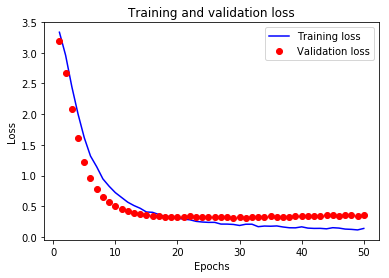

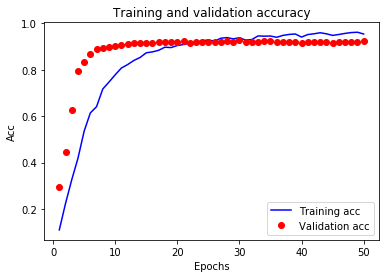

1200/1200 [==============================] - 2s 2ms/step

Results:
Train_acc: 0.841
Val_acc: 0.885
Test_acc: 0.922
F1-score: 0.922


In [16]:
plot_results(history)
evaluation()

## 13.? Mögliche Fehler

- Fehlermeldung "OOM when allocating tensor with..." (siehe unten) → GPU ist <i>out of memory</i>, d.h. es ist nicht genug GPU Speicher vorhanden. Dieser Fehler ist mir sehr oft begegnet und es ist sehr frustrierend, wenn nach 4 Stunden Parameteroptimierung dieser Fehler die Suche abbricht. Deshalb sollte auf jeden Fall zu Beginn eine geringe Batch-Size gewählt werden und nicht zu viele Parameter auf einmal trainiert werden.

In [8]:
%%time
best_run, best_model = optim.minimize(model=create_model,
                                      data=data,
                                      algo=tpe.suggest,
                                      max_evals=10,
                                      trials=Trials(),
                                      notebook_name='Kapitel 13 - Hyperparameteroptimierung mit Keras')

>>> Imports:
#coding=utf-8

try:
    from keras import backend as K
except:
    pass

try:
    from keras import models
except:
    pass

try:
    from keras import layers
except:
    pass

try:
    from keras.optimizers import Adam, RMSprop, SGD
except:
    pass

try:
    from keras.utils.np_utils import to_categorical
except:
    pass

try:
    from keras.callbacks import EarlyStopping
except:
    pass

try:
    from keras import regularizers
except:
    pass

try:
    from keras.layers import Dropout
except:
    pass

try:
    from keras.layers.core import Dense, Dropout, Activation
except:
    pass

try:
    from sklearn.metrics import f1_score
except:
    pass

try:
    from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
except:
    pass

try:
    from sklearn.preprocessing import LabelEncoder, OneHotEncoder
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    from hyperas.distributions import uniform
e

 - 10s - loss: 0.0277 - acc: 0.9908 - val_loss: 0.2504 - val_acc: 0.9358         

Epoch 19/75                                                                      
 - 10s - loss: 0.0293 - acc: 0.9906 - val_loss: 0.2377 - val_acc: 0.9417         

Epoch 20/75                                                                      
 - 10s - loss: 0.0231 - acc: 0.9936 - val_loss: 0.2347 - val_acc: 0.9383         

Epoch 21/75                                                                      
 - 10s - loss: 0.0192 - acc: 0.9956 - val_loss: 0.2541 - val_acc: 0.9392         

Epoch 22/75                                                                      
 - 10s - loss: 0.0166 - acc: 0.9961 - val_loss: 0.2461 - val_acc: 0.9425         

Epoch 23/75                                                                      
 - 10s - loss: 0.0149 - acc: 0.9961 - val_loss: 0.2584 - val_acc: 0.9367         

Epoch 24/75                                                                      
 - 10s - l

Epoch 42/75                                                                      
 - 10s - loss: 0.0753 - acc: 0.9756 - val_loss: 0.3288 - val_acc: 0.9292         

Epoch 43/75                                                                      
 - 10s - loss: 0.0574 - acc: 0.9819 - val_loss: 0.3498 - val_acc: 0.9242         

Epoch 44/75                                                                      
 - 10s - loss: 0.0666 - acc: 0.9792 - val_loss: 0.3489 - val_acc: 0.9258         

Epoch 45/75                                                                      
 - 10s - loss: 0.0639 - acc: 0.9789 - val_loss: 0.3383 - val_acc: 0.9258         

Epoch 46/75                                                                      
 - 10s - loss: 0.0636 - acc: 0.9786 - val_loss: 0.3613 - val_acc: 0.9267         

Epoch 47/75                                                                      
 - 10s - loss: 0.0640 - acc: 0.9786 - val_loss: 0.3512 - val_acc: 0.9242         

Epoch 48/7

 - 13s - loss: 0.0102 - acc: 0.9975 - val_loss: 0.4323 - val_acc: 0.9383         

Epoch 66/75                                                                      
 - 13s - loss: 0.0016 - acc: 0.9997 - val_loss: 0.4426 - val_acc: 0.9383         

Epoch 67/75                                                                      
 - 13s - loss: 0.0048 - acc: 0.9986 - val_loss: 0.4273 - val_acc: 0.9400         

Epoch 68/75                                                                      
 - 13s - loss: 0.0036 - acc: 0.9981 - val_loss: 0.4305 - val_acc: 0.9408         

Epoch 69/75                                                                      
 - 13s - loss: 0.0024 - acc: 0.9992 - val_loss: 0.4694 - val_acc: 0.9367         

Epoch 70/75                                                                      
 - 13s - loss: 0.0019 - acc: 0.9992 - val_loss: 0.4130 - val_acc: 0.9408         

Epoch 71/75                                                                      
 - 13s - l

 - 10s - loss: 0.3337 - acc: 0.9097 - val_loss: 0.2896 - val_acc: 0.9250           

Epoch 12/75                                                                        
 - 10s - loss: 0.2905 - acc: 0.9200 - val_loss: 0.2705 - val_acc: 0.9242           

Epoch 13/75                                                                        
 - 10s - loss: 0.2583 - acc: 0.9225 - val_loss: 0.2632 - val_acc: 0.9267           

Epoch 14/75                                                                        
 - 10s - loss: 0.2417 - acc: 0.9322 - val_loss: 0.2559 - val_acc: 0.9283           

Epoch 15/75                                                                        
 - 10s - loss: 0.2384 - acc: 0.9292 - val_loss: 0.2493 - val_acc: 0.9325           

Epoch 16/75                                                                        
 - 10s - loss: 0.2124 - acc: 0.9336 - val_loss: 0.2415 - val_acc: 0.9292           

Epoch 17/75                                                           

Epoch 33/75                                                                      
 - 13s - loss: 0.0488 - acc: 0.9853 - val_loss: 0.2996 - val_acc: 0.9350         

Epoch 34/75                                                                      
 - 13s - loss: 0.0464 - acc: 0.9842 - val_loss: 0.3125 - val_acc: 0.9308         

Epoch 35/75                                                                      
 - 13s - loss: 0.0506 - acc: 0.9822 - val_loss: 0.3176 - val_acc: 0.9258         

Epoch 36/75                                                                      
 - 13s - loss: 0.0460 - acc: 0.9844 - val_loss: 0.3125 - val_acc: 0.9283         

Epoch 37/75                                                                      
 - 13s - loss: 0.0338 - acc: 0.9886 - val_loss: 0.3186 - val_acc: 0.9325         

Epoch 38/75                                                                      
 - 13s - loss: 0.0427 - acc: 0.9864 - val_loss: 0.3103 - val_acc: 0.9308         

Epoch 39/7

 - 11s - loss: 0.0021 - acc: 0.9992 - val_loss: 0.3175 - val_acc: 0.9417         

Epoch 57/75                                                                      
 - 11s - loss: 0.0015 - acc: 0.9994 - val_loss: 0.3422 - val_acc: 0.9400         

Epoch 58/75                                                                      
 - 11s - loss: 0.0032 - acc: 0.9989 - val_loss: 0.3506 - val_acc: 0.9408         

Epoch 59/75                                                                      
 - 11s - loss: 0.0043 - acc: 0.9994 - val_loss: 0.3219 - val_acc: 0.9425         

Epoch 60/75                                                                      
 - 11s - loss: 0.0034 - acc: 0.9986 - val_loss: 0.3253 - val_acc: 0.9433         

Epoch 61/75                                                                      
 - 11s - loss: 4.1164e-04 - acc: 1.0000 - val_loss: 0.3497 - val_acc: 0.9417     

Epoch 62/75                                                                      
 - 11s - l

ResourceExhaustedError: OOM when allocating tensor with shape[281396,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training_19/RMSprop/mul_2 = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](RMSprop_19/lr/read, training_19/RMSprop/gradients/dense_58/MatMul_grad/MatMul_1)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
